# iPerturb: An Introduction

## Overview

iPerturb is an efficient tool for integrating single-cell RNA sequencing (scRNA-seq) data with multiple samples and multiple conditions, focusing on removing batch effects while retaining condition-specific changes in gene expression. This document will introduce how to use iPerturb to process and analyze scRNA-seq datasets from different experimental conditions.

## Dataset Description

We applied iPerturb to analyze droplet-based scRNA-seq data from peripheral blood mononuclear cells (PBMCs). The dataset consists of two groups: one group includes peripheral blood cells treated with interferon-β (INF-β), and the other group includes untreated control cells. You can download the dataset from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583).

Specifically, gene expression levels were measured from 8 experimental samples treated with INF-β (stimulated group; N = 7466 cells) and 8 control samples (control group; N = 6573 cells) to assess condition-specific changes in gene expression.

## Loading

Let's start by loading the required packages. We import the `iPerturb.iperturb` package as `iPerturb`. We also need to import the following two packages to ensure iPerturb works properly:

- `scanpy`: iPerturb is built on the `scanpy` framework and accepts single-cell data files in the h5ad format.
- `torch`: iPerturb uses `pytorch` to build the variational autoencoder and use `cuda` to accelerate the inference, we need to detect if cuda is avaliable.

In [3]:
import iperturb as iPerturb
import torch
import scanpy as sc

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available')
else:
    print('cuda is not available')

anndata = sc.read_h5ad('/data/chenyz/iPerturb_project/data/Pbmc.h5ad')

cuda is not available


## Preprocessing

Data preprocessing of `anndata` included the following steps:

1. **Quality Control**: Removal of low-quality cells and genes (default: min_genes=200, min_cells=3).
   
2. **Normalization**: Standardizing gene expression data (default: `normalize_total()`, `log1p()`).
   
3. **Dataset initiation**: Batch, condition, and groundtruth (optional) information are added to `anndata.obs` and set as category types.

4. **Find highly variable genes**: Annotate highly variable genes to accelerate integration (default: n_top_genes=4000).


In iPerturb, we provide a unified function `preprocess.data_load()` to accomplish this:

In [5]:
batch_key = 'batch_2'
condition_key = 'batch'
groundtruth_key = 'groundtruth'
datasets,raw,var_names,index_names = iPerturb.preprocess.data_load(anndata, batch_key = batch_key ,condition_key = condition_key , groundtruth_key = groundtruth_key ,n_top_genes = 4000)

/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Model initiating
After preprocessing the data, the next step is to initiate the model. Here are the steps to set up and initiate the iPerturb model:

1. **Create Hyperparameters**: We start by creating the hyperparameters for the model using the `utils.create_hyper()` function.

2. **Define Training Parameters**: We define the training parameters including the number of epochs and the optimizer. In this example, we use the Adam optimizer.

3. **Initialize the Model**: Next, we initialize the iPerturb model using the `model.model_init_ function()`. This function sets up the model with the specified hyperparameters, latent dimensions, optimizer, learning rate, and other parameters. Here are the explanation of Parameters:

- `hyper`: The hyperparameters created in step 1.
   
- `latent_dim1`, `latent_dim2`, `latent_dim3`: Dimensions of the latent variable of Z, Z_t and Z_s.
   
- `optimizer`: The optimizer used for training, in this case, Adam.
   
- `lr`: Learning rate for the optimizer.
   
- `gamma`: Learning rate decay factor.
   
- `milestones`: Epochs at which the learning rate is decayed.
   
- `set_seed`: Random seed for reproducibility.
   
- `cuda`: Boolean indicating whether to use GPU for training.
   
- `alpha`: Regularization parameter.

Finally, we got 3 key component as output to strat VAE infernce(reference by [Pyro](https://pyro.ai/)):
- `svi`: Stochastic Variational Inference (SVI) object used for optimizing the variational inference objective in the variational autoencoder (VAE) model.
  
- `scheduler`: Learning rate scheduler that adjusts the learning rate during training based on the specified milestones and gamma.
  
- `iPerturb_model`: The initialized iPerturb model, which includes the variational autoencoder (VAE) architecture configured with the specified hyperparameters and settings.

In [6]:
######### iPerturb
hyper = iPerturb.utils.create_hyper(datasets, var_names, index_names)
# 训练模型
epochs = 30
optimizer = torch.optim.Adam

svi, scheduler, iPerturb_model = iPerturb.model.model_init_(hyper, latent_dim1=100, latent_dim2=20, latent_dim3=20, 
                                                            optimizer=optimizer, lr=0.006, gamma=0.2, milestones=[20], 
                                                            set_seed=123, cuda=cuda, alpha=1e-4)

## Model training
Once the iPerturb model is initialized, we proceed to train the model using the `model.RUN()` function. The parameter `if_likelihood` is used to compute the model's t_logits. The model returns two results: `x_pred`, which represents the corrected matrix, and `reconstruct_data`, which represents the corrected AnnData.

iPerturb is computationally efficient, with a typical runtime of approximately 5-10 minutes in this example.

In [7]:
x_pred, reconstruct_data = iPerturb.model.RUN(datasets, iPerturb_model, svi, scheduler, epochs, hyper, raw, cuda, batch_size=100, if_likelihood=True)

/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'t_logit'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[Epoch 00]  Loss: 2.91699
[Epoch 01]  Loss: 2.12148
[Epoch 02]  Loss: 1.59471
[Epoch 03]  Loss: 1.35417
[Epoch 04]  Loss: 1.24790
[Epoch 05]  Loss: 1.19133
[Epoch 06]  Loss: 1.15570
[Epoch 07]  Loss: 1.13036
[Epoch 08]  Loss: 1.11083
[Epoch 09]  Loss: 1.09498
[Epoch 10]  Loss: 1.08158
[Epoch 11]  Loss: 1.07002
[Epoch 12]  Loss: 1.05984
[Epoch 13]  Loss: 1.05086
[Epoch 14]  Loss: 1.04273
[Epoch 15]  Loss: 1.03514
[Epoch 16]  Loss: 1.02849
[Epoch 17]  Loss: 1.02211
[Epoch 18]  Loss: 1.01625
[Epoch 19]  Loss: 1.01052
[Epoch 20]  Loss: 1.00481
[Epoch 21]  Loss: 1.00085
[Epoch 22]  Loss: 0.99856
[Epoch 23]  Loss: 0.99671
[Epoch 24]  Loss: 0.99487
[Epoch 25]  Loss: 0.99321
[Epoch 26]  Loss: 0.99165
[Epoch 27]  Loss: 0.99003
[Epoch 28]  Loss: 0.98844
[Epoch 29]  Loss: 0.98681
Finished training! Time:807.2789435386658.


## Results
1. we visualize the UMAP plots before and after integration to demonstrate the effectiveness of iPerturb integration.


/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/umap/distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/umap/distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-pac

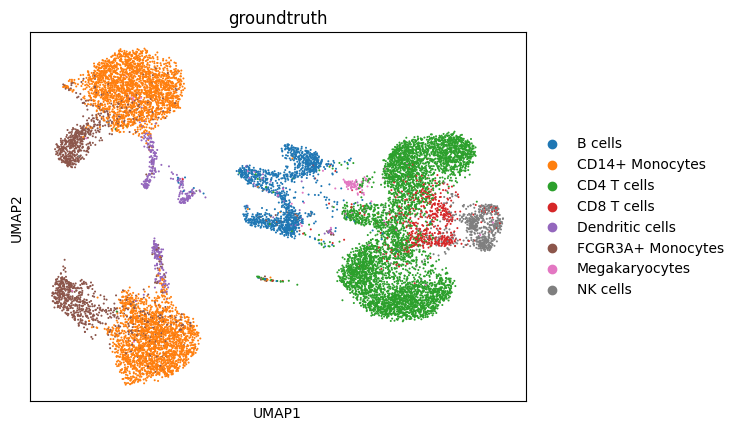

In [8]:
# UMAP before integration
sc.pp.normalize_total(raw)
sc.pp.log1p(raw)
sc.pp.scale(raw)
sc.tl.pca(raw)
sc.pp.neighbors(raw, n_neighbors=30,n_pcs=50)
sc.tl.umap(raw)
sc.pl.umap(raw, color = 'groundtruth')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


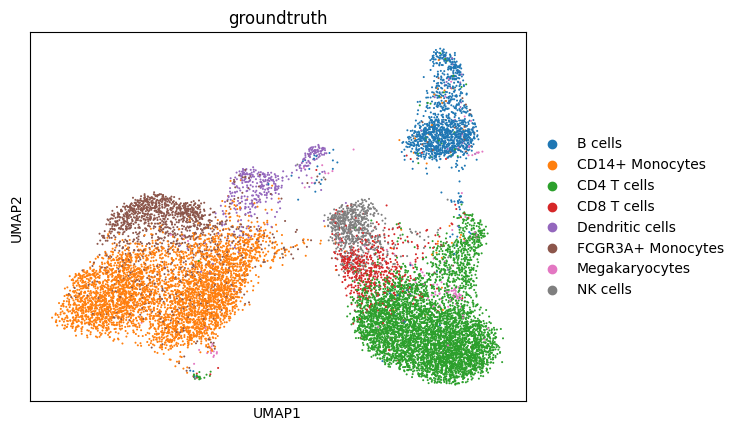

In [9]:
# UMAP after integration
sc.pp.neighbors(reconstruct_data, n_neighbors=30,n_pcs=50)
sc.tl.umap(reconstruct_data)
sc.pl.umap(reconstruct_data, color = 'groundtruth')

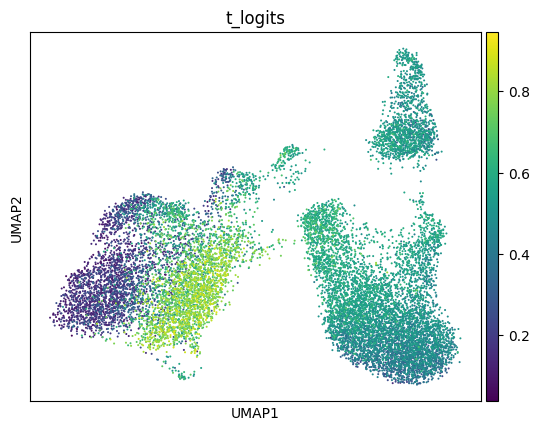

In [10]:
# UMAP after integration by t_logits
sc.pl.umap(reconstruct_data, color = 't_logits')

2. we calculate the EMD (Earth Mover's Distance) between the t_logits of the experimental and control groups, divided by cell type, to illustrate that the model's t_logits can explain the perturbation intensity at the cellular level.


In [14]:
import numpy as np
import pandas as pd
import ot #### Python Optimal Transport: pip install POT
from scipy.spatial.distance import cdist
def calc_EMD(a,b):
    distance_matrix = cdist(a, b)
    a_weights = np.ones(a.shape[0]) / a.shape[0]
    b_weights = np.ones(b.shape[0]) / b.shape[0]
    # 计算EMD
    emd_distance = ot.emd2(a_weights, b_weights, distance_matrix)

    return emd_distance

celltype = reconstruct_data.obs['groundtruth'].unique() 
condition = reconstruct_data.obs['batch'].unique() 
df_all = pd.DataFrame(columns=['groundtruth', 'emd'])  
for key in celltype:
        adata_subset = reconstruct_data[reconstruct_data.obs['groundtruth'] == key]
        P = adata_subset[adata_subset.obs['batch'] == condition[0]].obsm['t_logits']
        Q = adata_subset[adata_subset.obs['batch'] == condition[1]].obsm['t_logits']
        emd = calc_EMD(P, Q)
        df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)  
        print(f'{key} is done!')

print(df_all)

/home/chenyz/anaconda3/envs/MOBA_Billy/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)


CD14+ Monocytes is done!
Dendritic cells is done!


/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)


CD4 T cells is done!
CD8 T cells is done!
Megakaryocytes is done!
B cells is done!
FCGR3A+ Monocytes is done!
NK cells is done!
         groundtruth       emd
0    CD14+ Monocytes  0.588356
1    Dendritic cells  0.235815
2        CD4 T cells  0.039417
3        CD8 T cells  0.010078
4     Megakaryocytes  0.133342
5            B cells  0.030089
6  FCGR3A+ Monocytes  0.500720
7           NK cells  0.021472


/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
/tmp/ipykernel_4268/3216307904.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append({'groundtruth': key, 'emd': emd}, ignore_index=True)
